In [1]:
import pandas as pd
import numpy as np
import glob
import os
import random
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [2]:
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, LSTM, Flatten
from keras.utils import to_categorical


Using TensorFlow backend.


In [3]:
#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
#import keras as keras
#from keras import Sequential
#from keras.layers import LSTM, Dense, LSTM, Flatten
#from keras.utils import to_categorical

#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import tensorflow

import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend

In [4]:
enc = pickle.load( open( "pickle\\enc.p", "rb" ) )

C:\Users\jgomezm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator OneHotEncoder from version 0.21.3 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [5]:
val_x = pickle.load( open( "pickle\\val_x.p", "rb" ) )
train_x = pickle.load( open( "pickle\\train_x.p", "rb" ) )
val_labels = pickle.load( open( "pickle\\val_labels.p", "rb" ) )
train_labels = pickle.load( open( "pickle\\train_labels.p", "rb" ) )
class_weights = pickle.load( open( "pickle\\class_weights.p", "rb" ) )
class_weights

array([1.92811562, 0.99980535, 1.81855196, 1.10213496, 1.15103641,
       1.05299303, 1.92378277, 2.5068326 , 0.5429417 , 1.10963491,
       0.92002508, 0.4070288 ])

In [6]:
print(train_x.shape)
print(len(train_labels))

(41092, 200, 27)
41092


### Define Model

In [7]:
train_x.shape

(41092, 200, 27)

In [8]:
train_labels.shape

(41092, 12)

In [9]:
np.sum(train_labels, axis = 0)

array([1776., 3425., 1883., 3107., 2975., 3252., 1780., 1366., 6307.,
       3086., 3722., 8413.])

In [10]:
np.sum(val_labels, axis = 0)

array([ 436.,  781.,  469.,  833.,  671.,  862.,  454.,  316., 1849.,
        785.,  936., 2103.])

In [11]:
max(np.sum(train_labels, axis = 0))/sum(np.sum(train_labels, axis = 0))

0.2047357149810182

In [12]:
max(np.sum(val_labels, axis = 0))/sum(np.sum(val_labels, axis = 0))

0.200381133873273

In [13]:
enc.categories_[0]

array(['AU', 'CO', 'EC', 'GB', 'HK', 'JP', 'MX', 'NZ', 'TN', 'TR', 'US',
       'ZA'], dtype=object)

### 3 LSTM model

In [14]:
out_index = 2
model = keras.Sequential()
model.add(LSTM(25, 
               input_shape=(train_x.shape[1], train_x.shape[2]), 
               return_sequences = True))
model.add(LSTM(50, 
               input_shape=(train_x.shape[1], train_x.shape[2]), 
               return_sequences = True))
model.add(LSTM(100, 
               input_shape=(train_x.shape[1], train_x.shape[2]), 
               return_sequences = False))
model.add(Dense(len(enc.categories_[0]), activation= "softmax"))

In [17]:
adam = keras.optimizers.Adam(lr=0.001)
model.compile(loss = "categorical_crossentropy", optimizer= adam, metrics=["acc"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200, 25)           5300      
_________________________________________________________________
lstm_1 (LSTM)                (None, 200, 50)           15200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense (Dense)                (None, 12)                1212      
Total params: 82,112
Trainable params: 82,112
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
model.fit(train_x, train_labels,
          epochs = 5, 
          shuffle = True,
          validation_data = (val_x, val_labels),
          batch_size = 512,
         class_weight = class_weights)

Train on 41092 samples, validate on 10495 samples
Epoch 1/5
41092/41092 [==============================] - 185s 4ms/sample - loss: 2.3479 - acc: 0.2045 - val_loss: 2.3301 - val_acc: 0.2004
Epoch 2/5
41092/41092 [==============================] - 195s 5ms/sample - loss: 2.3462 - acc: 0.2047 - val_loss: 2.3332 - val_acc: 0.2004
Epoch 3/5
41092/41092 [==============================] - 211s 5ms/sample - loss: 2.3448 - acc: 0.2047 - val_loss: 2.3295 - val_acc: 0.2004
Epoch 4/5
41092/41092 [==============================] - 223s 5ms/sample - loss: 2.3450 - acc: 0.2042 - val_loss: 2.3274 - val_acc: 0.2003
Epoch 5/5
41092/41092 [==============================] - 228s 6ms/sample - loss: 2.3435 - acc: 0.2050 - val_loss: 2.3289 - val_acc: 0.2005


In [20]:
preds = model.predict(val_x, batch_size = 256, verbose = 1)
print(np.sum(preds, axis = 0))
print(np.sum(val_labels, axis = 0))

10495/10495 [==============================] - 8s 802us/sample
[ 419.18     818.3404   469.60016  841.30597  726.1219   797.6946
  444.03616  303.56003 1568.2731   780.71844  935.0686  2391.2947 ]
[ 436.  781.  469.  833.  671.  862.  454.  316. 1849.  785.  936. 2103.]


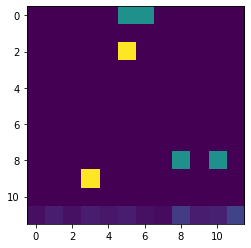

In [21]:
plt.imshow(
    confusion_matrix(
        enc.inverse_transform(preds), 
        enc.inverse_transform(val_labels), 
        normalize = "true"
    )
)

In [22]:
adam = keras.optimizers.Adam(lr=0.0001)
model.compile(loss = "categorical_crossentropy", optimizer= adam, metrics=["acc"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200, 25)           5300      
_________________________________________________________________
lstm_1 (LSTM)                (None, 200, 50)           15200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense (Dense)                (None, 12)                1212      
Total params: 82,112
Trainable params: 82,112
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.fit(train_x, train_labels,
          epochs = 45, 
          shuffle = True,
          validation_data = (val_x, val_labels),
          batch_size = 512,
         class_weight = class_weights)

Train on 41092 samples, validate on 10495 samples
Epoch 1/45
41092/41092 [==============================] - 239s 6ms/sample - loss: 2.3421 - acc: 0.2053 - val_loss: 2.3273 - val_acc: 0.2017
Epoch 2/45
41092/41092 [==============================] - 236s 6ms/sample - loss: 2.3414 - acc: 0.2057 - val_loss: 2.3271 - val_acc: 0.2017
Epoch 3/45
41092/41092 [==============================] - 242s 6ms/sample - loss: 2.3402 - acc: 0.2060 - val_loss: 2.3249 - val_acc: 0.2028
Epoch 4/45
18944/41092 [============>.................] - ETA: 2:03 - loss: 2.3322 - acc: 0.2055

In [ ]:
preds = model.predict(val_x, batch_size = 256, verbose = 1)
print(np.sum(preds, axis = 0))
print(np.sum(val_labels, axis = 0))

In [ ]:
plt.imshow(
    confusion_matrix(
        enc.inverse_transform(preds), 
        enc.inverse_transform(val_labels), 
        normalize = "true"
    )
)

### 3 LSTM w/ Dense

In [ ]:
model.pop()
for layer in model.layers:
    layer.trainable = False
model.layers[-1].trainable = True
model.add(Dense(100, activation = 'relu'))

model.add(Dense(len(enc.categories_[0]), activation= "softmax"))
model.compile(loss = "categorical_crossentropy", optimizer= adam, metrics=["acc"])
print(model.summary())

In [ ]:
model.fit(train_x, train_labels,
          epochs = 20, 
          shuffle = True,
          validation_data = (val_x, val_labels),
          batch_size = 512,
          class_weight=class_weights)

In [ ]:
preds = model.predict(val_x, batch_size = 256, verbose = 1)
print(np.sum(preds, axis = 0))
print(np.sum(val_labels, axis = 0))

In [ ]:
plt.imshow(
    confusion_matrix(
        enc.inverse_transform(preds), 
        enc.inverse_transform(val_labels), 
        normalize = "true"
    )
)

In [ ]:
model.pop()

for layer in model.layers:
    layer.trainable = False
model.layers[-1].trainable = True
model.add(keras.layers.Dropout(.25))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(len(enc.categories_[0]), activation= "softmax"))
model.compile(loss = "categorical_crossentropy", optimizer= adam, metrics=["acc"])
print(model.summary())

In [ ]:
model.fit(train_x, train_labels,
          epochs = 20, 
          shuffle = True,
          validation_data = (val_x, val_labels),
          batch_size = 512,
          class_weight=class_weights)

In [ ]:
preds = model.predict(val_x, batch_size = 256, verbose = 1)
print(np.sum(preds, axis = 0))
print(np.sum(val_labels, axis = 0))

In [ ]:
plt.imshow(
    confusion_matrix(
        enc.inverse_transform(preds), 
        enc.inverse_transform(val_labels), 
        normalize = "true"
    )
)

### Tune full network

In [ ]:
for layer in model.layers:
    layer.trainable = True
model.pop()
model.add(keras.layers.Dropout(.25))
model.add(Dense(len(enc.categories_[0]), activation= "softmax"))
model.compile(loss = "categorical_crossentropy", optimizer= adam, metrics=["acc"])
print(model.summary())

In [ ]:
model.fit(train_x, train_labels,
          epochs = 500, 
          shuffle = True,
          validation_data = (val_x, val_labels),
          batch_size = 256,
          class_weight=class_weights)

In [ ]:
preds = model.predict(val_x, batch_size = 256, verbose = 1)
print(np.sum(preds, axis = 0))
print(np.sum(val_labels, axis = 0))

In [ ]:
plt.imshow(
    confusion_matrix(
        enc.inverse_transform(preds), 
        enc.inverse_transform(val_labels), 
        normalize = "true"
    )
)